**Import necessary libraries**

In [1]:
import numpy as np
import shutil
import os
import cv2
import splitfolders
from keras_tuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**Prepare dataset**

In [2]:
# Define base directory path
base_dir = 'UTKFace'

In [3]:
def categorize_gender():
    genders = ['male', 'female']
    for gender in genders:
        new_path = os.path.join(base_dir, gender)
        if not os.path.exists(new_path):
            os.mkdir(new_path)
    
    for file in os.listdir(base_dir):
        if '.jpg' in file:
            label = file.split('_')[1]
            if label=='0':
                shutil.move(os.path.join(base_dir, file), os.path.join(os.path.join(base_dir, genders[0]), file))
            elif label=='1':
                shutil.move(os.path.join(base_dir, file), os.path.join(os.path.join(base_dir, genders[1]), file))
            

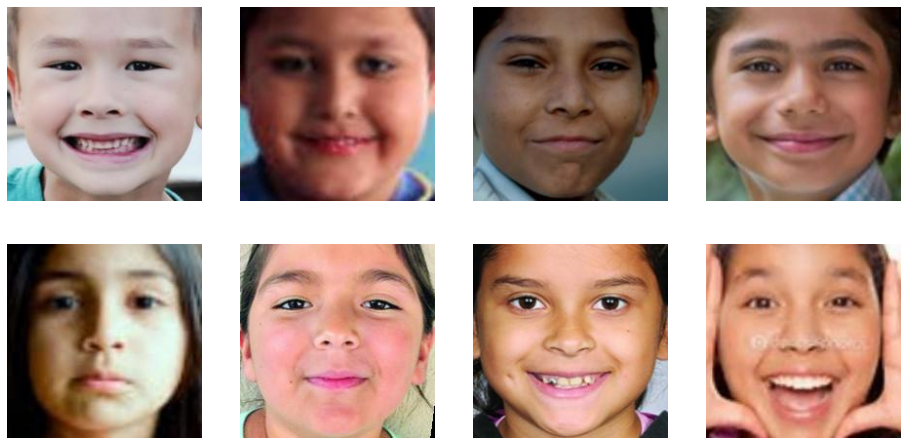

In [3]:
# Display image sample
nrows = 2
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_male = [os.path.join('UTKFace/train/male', fname) 
            for fname in os.listdir('UTKFace/train/male')[-4:]]
next_female = [os.path.join('UTKFace/train/female', fname) 
              for fname in os.listdir('UTKFace/train/female')[-4:]]

for i, img_path in enumerate(next_male+next_female):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [46]:
# Split data into train, val, and test
# splitfolders.ratio(base_dir, ratio=(0.8, 0.19, 0.01))

Copying files: 23708 files [09:09, 43.16 files/s]


In [3]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    rescale=(1.0/255.0))
datagen = ImageDataGenerator(rescale=(1.0/255.0))

In [4]:
train_iterator = train_datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train/'),
    target_size=(128, 128))

Found 18965 images belonging to 2 classes.


In [5]:
val_iterator = datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'val/'),
    target_size=(128, 128))

Found 4504 images belonging to 2 classes.


In [6]:
test_iterator = datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test/'),
    target_size=(128, 128))

Found 239 images belonging to 2 classes.


**Build and train model**

In [8]:
# build model for hyperparameter tuning
def hyper_model(hp):
  model = Sequential()
  
  model.add(InputLayer(input_shape=(200, 200, 3)))
  model.add(Conv2D(filters=hp.Int("conv_1", min_value=16, max_value=32, step=16), kernel_size=3, padding="same", activation="relu"))
  model.add(MaxPool2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(filters=hp.Int("conv_2", min_value=32, max_value=64, step=16), kernel_size=3, padding="same", activation="relu"))
  model.add(MaxPool2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Conv2D(filters=hp.Int("conv_3", min_value=64, max_value=96, step=16), kernel_size=3, padding="same", activation="relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(units=hp.Int("dense", min_value=96, max_value=128, step=16), activation="relu"))
  model.add(Dense(2, activation="softmax"))
  
  model.compile(optimizer=Adam(
      learning_rate=hp.Choice("learning_rate", values=[1e-3, 1e-4])),
      loss="binary_crossentropy",
      metrics=["acc"])
  
  return model

In [31]:
# build model
def build_model():
  model = Sequential(name="sequential")
  
  model.add(InputLayer(input_shape=(128, 128, 3)))
  model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPool2D())
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPool2D())
  model.add(Dropout(0.5))
  model.add(BatchNormalization())
  model.add(Conv2D(filters=96, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPool2D())
  model.add(MaxPool2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(units=128, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  
  model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-8),
    loss='categorical_crossentropy',
    metrics=['acc'])
  
  return model

In [32]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 64)       0

In [33]:
callback = [ModelCheckpoint(filepath="saved/model_weights_v12_relu.h5", verbose=1, monitor="val_loss", save_best_only=True)]

history = model.fit(
    train_iterator,
    validation_data=val_iterator,
    epochs=100,
    batch_size=32,
    callbacks=callback)

Epoch 1/100
593/593 [==============================] - ETA: 0s - loss: 0.8147 - acc: 0.6323
Epoch 00001: val_loss improved from inf to 2.74555, saving model to saved\model_weights_v12_relu.h5
593/593 [==============================] - 409s 686ms/step - loss: 0.8147 - acc: 0.6323 - val_loss: 2.7456 - val_acc: 0.4774
Epoch 2/100
593/593 [==============================] - ETA: 0s - loss: 0.5912 - acc: 0.6869
Epoch 00002: val_loss improved from 2.74555 to 0.55270, saving model to saved\model_weights_v12_relu.h5
593/593 [==============================] - 380s 640ms/step - loss: 0.5912 - acc: 0.6869 - val_loss: 0.5527 - val_acc: 0.7242
Epoch 3/100
593/593 [==============================] - ETA: 0s - loss: 0.5624 - acc: 0.7084
Epoch 00003: val_loss improved from 0.55270 to 0.52011, saving model to saved\model_weights_v12_relu.h5
593/593 [==============================] - 378s 637ms/step - loss: 0.5624 - acc: 0.7084 - val_loss: 0.5201 - val_acc: 0.7427
Epoch 4/100
593/593 [====================

**Evaluation**

In [34]:
def eval_plot(epochs):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

  ax1.plot(np.arange(0, epochs), history.history["acc"], label="train_acc")
  ax1.plot(np.arange(0, epochs), history.history["val_acc"], label="val_acc")
  ax1.set_title('Acc Result Plot')
  ax1.set(xlabel='Epoch #', ylabel='Acc')
  ax1.legend(loc="lower right")

  ax2.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
  ax2.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
  ax2.set_title('Loss Result Plot')
  ax2.set(xlabel='Epoch #', ylabel='Loss')
  ax2.legend(loc="upper right")

  fig.savefig("saved/acc_loss_plot_v12_relu.svg", format="svg")

  plt.show()

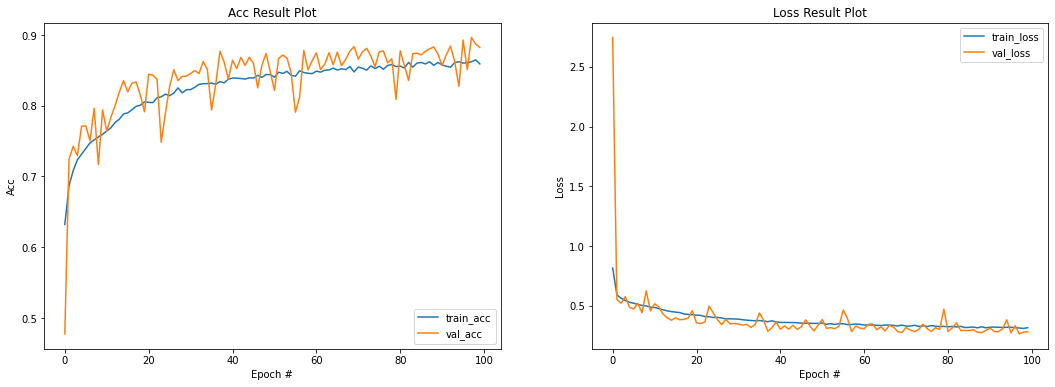

In [35]:
eval_plot(100)

In [111]:
loaded_model = load_model("saved/model_weights_v12_relu.h5")

In [105]:
eval_result = loaded_model.evaluate(test_iterator)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 1s 146ms/step - loss: 0.2506 - acc: 0.8954
[test loss, test accuracy]: [0.2506351172924042, 0.8953974843025208]


In [38]:
def extract_data(data_iterator):
  x_data, y_data = next(data_iterator)

  batch_index = 0
  while batch_index <= data_iterator.batch_index:
    x , y = next(data_iterator)
    x_data = np.append(x_data, x, axis=0)
    y_data = np.append(y_data, y, axis=0)
    batch_index = batch_index + 1

  return x_data, y_data

In [16]:
x_test, y_test = extract_data(test_iterator)

In [106]:
pred = loaded_model.predict(x_test)
y_pred = (pred > 0.5).astype(np.int32)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       114
           1       0.88      0.92      0.90       125

   micro avg       0.90      0.90      0.90       239
   macro avg       0.90      0.89      0.89       239
weighted avg       0.90      0.90      0.90       239
 samples avg       0.90      0.90      0.90       239



<AxesSubplot:>

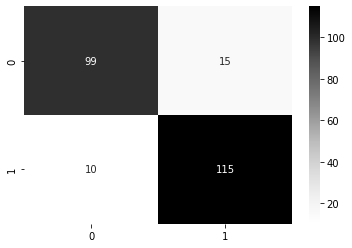

In [107]:
cf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, cmap='Greys', fmt='g')

**Prediction**



---



In [42]:
train_iterator.class_indices

{'female': 0, 'male': 1}

In [4]:
def predictFuncNew(path):
  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  labels = ['female', 'male']
  predicted_gender = []
  
  img_upload = cv2.imread(path)
  gray = cv2.cvtColor(img_upload, cv2.COLOR_BGR2GRAY)
  img_height = img_upload.shape[0]
  
  faces = face_cascade.detectMultiScale(gray, 1.31, 4)
  for (x, y, w, h) in faces:
    img = gray[y-10:y+h+10, x-10:x+w+10]
    img = cv2.cvtColor(np.array(img), cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, model.layers[0].output_shape[1:3])
    img = img.astype('float32')/255.0 
    img = np.expand_dims(img, axis=0)
    pred = loaded_model.predict(img)
    index_label = int(pred.argmax(axis=1))
    label_pred = labels[index_label]
    predicted_gender.append(label_pred)
    pred_prob = pred[0][index_label]
    col = (0, 0, 0)
    result = str(round(pred_prob*100, 2))+"% "+str(label_pred)
    cv2.rectangle(img_upload, (x-10, y-10), (x+w+10, y+h+10), col, 3)
    (tw, th), _ = cv2.getTextSize(
      result, cv2.FONT_HERSHEY_SIMPLEX, img_height*0.00125, 3)
    cv2.rectangle(img_upload, (x-10, y+h+10), (x+tw, y+h+15+th), col, -1)
    cv2.putText(
      img=img_upload, 
      text=result, 
      org=(x-5, y+h+10+th), 
      fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
      fontScale=img_height*0.00125, 
      color=(255, 255, 255), 
      thickness=2)

  # print(str(round(pred_prob*100, 2))+"% "+str(label_pred))  
  new_image = cv2.cvtColor(img_upload, cv2.COLOR_BGR2RGB)
  plt.figure(dpi=100)
  plt.imshow(new_image)
  plt.show()

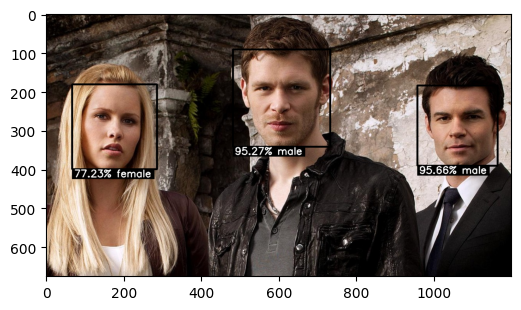

In [15]:
predict_path = 'test-images/test-img-originals.jpg'
predictFuncNew(predict_path)